Import Necessary Libraries

In [2]:
import os

from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

Import Yamnet Model

In [2]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

Audio Preprocessing

In [8]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

Data Loading (Custom Samples)

In [4]:
import pandas as pd
import os

# Define input folder containing the preprocessed audio files
input_folder = r'AudioSet\new_created'

# Initialize lists to store data
file_paths = []
class_names = []

# Define the maximum number of files per category
max_files_per_category = 700

# Iterate over each file in the input folder
for file_name in os.listdir(input_folder):
    folder_path = os.path.join(input_folder, file_name)
    
    # Check if the item is a directory
    if os.path.isdir(folder_path):
        class_name = file_name  # Use folder name as class name
        file_count = 0  # Counter for the number of files per category
        
        # Iterate over files in the directory
        for file in os.listdir(folder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(file_name, file)  # Changed to only file_name
                
                # Append file path and class name to lists
                file_paths.append(file_path)
                class_names.append(class_name)
                
                file_count += 1
                if file_count >= max_files_per_category:
                    break  # Break the loop if maximum files per category reached

# Create DataFrame from the collected data
preprocessed_df = pd.DataFrame({
    'filename': file_paths,
    'category': class_names
})

# Display DataFrame
pd_data = preprocessed_df

pd_data



,filename,category
0,book_page_flip\a5-book-flipping-02-55290_01_Ad...,book_page_flip
1,book_page_flip\a5-book-flipping-02-55290_01_Ad...,book_page_flip
2,book_page_flip\a5-book-flipping-02-55290_01_Ga...,book_page_flip
3,book_page_flip\a5-book-flipping-02-55290_01_Pi...,book_page_flip
4,book_page_flip\a5-book-flipping-02-55290_01_Pi...,book_page_flip
...,...,...
7695,Vacuum_cleaner\Vacuum cleaner_516_aug_PitchShi...,Vacuum_cleaner
7696,Vacuum_cleaner\Vacuum cleaner_516_aug_PitchShi...,Vacuum_cleaner
7697,Vacuum_cleaner\Vacuum cleaner_516_aug_PitchShi...,Vacuum_cleaner
7698,Vacuum_cleaner\Vacuum cleaner_516_aug_PitchShi...,Vacuum_cleaner


Data Loading (Complete)

In [5]:
# import pandas as pd
# import os

# # Define input folder containing the preprocessed audio files
# input_folder = r'AudioSet\new_created'

# # Initialize lists to store data
# file_paths = []
# class_names = []

# # Iterate over each file in the input folder
# for file_name in os.listdir(input_folder):
#     folder_path = os.path.join(input_folder, file_name)
    
#     # Check if the item is a directory
#     if os.path.isdir(folder_path):
#         class_name = file_name  # Use folder name as class name
        
#         # Iterate over files in the directory
#         for file in os.listdir(folder_path):
#             if file.endswith(".wav"):
#                 file_path = os.path.join(file_name, file)  # Changed to only file_name
                
#                 # Append file path and class name to lists
#                 file_paths.append(file_path)
#                 class_names.append(class_name)

# # Create DataFrame from the collected data
# preprocessed_df = pd.DataFrame({
#     'filename': file_paths,
#     'category': class_names
# })

# # Display DataFrame
# pd_data = preprocessed_df

# pd_data


In [6]:
base_data_path = 'AudioSet\new_created'


Filter the data

In [7]:
# Your specified classes
my_classes = ['Silence', 'Male speech, man speaking', 'Female speech, woman speaking', 
              'Vacuum cleaner', 'Computer keyboard', 'Clicking', 'Sneeze', 
              'Cough', 'Laughter', 'Hair dryer', 'book_page_flip']

# Mapping classes to IDs
map_class_to_id = {'Silence': 0, 'Male speech, man speaking': 1, 'Female speech, woman speaking': 2, 
                   'Vacuum cleaner': 3, 'Computer keyboard': 4, 'Clicking': 5, 'Sneeze': 6, 
                   'Cough': 7, 'Laughter': 8, 'Hair dryer': 9, 'book_page_flip': 10}

# Filter the data based on specified classes
filtered_pd = pd_data[pd_data.category.isin(my_classes)]

# Assign IDs to the classes
class_id = filtered_pd['category'].apply(lambda name: map_class_to_id[name])
filtered_pd = filtered_pd.assign(target=class_id)

filtered_pd['filename'] = filtered_pd['filename'].apply(lambda row: os.path.join("AudioSet\\new_created", row))

# Display the first 10 rows
filtered_pd.head(10)


,filename,category,target
0,AudioSet\new_created\book_page_flip\a5-book-fl...,book_page_flip,10
1,AudioSet\new_created\book_page_flip\a5-book-fl...,book_page_flip,10
2,AudioSet\new_created\book_page_flip\a5-book-fl...,book_page_flip,10
3,AudioSet\new_created\book_page_flip\a5-book-fl...,book_page_flip,10
4,AudioSet\new_created\book_page_flip\a5-book-fl...,book_page_flip,10
5,AudioSet\new_created\book_page_flip\a5-book-fl...,book_page_flip,10
6,AudioSet\new_created\book_page_flip\a5-book-fl...,book_page_flip,10
7,AudioSet\new_created\book_page_flip\a5-book-fl...,book_page_flip,10
8,AudioSet\new_created\book_page_flip\a5-book-fl...,book_page_flip,10
9,AudioSet\new_created\book_page_flip\a5-book-fl...,book_page_flip,10


Load the audio files and retrieve embeddings

In [8]:
filenames = filtered_pd['filename']
targets = filtered_pd['target']

main_ds = tf.data.Dataset.from_tensor_slices((filenames, targets))
main_ds.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [9]:
def load_wav_for_map(filename, label):
  return load_wav_16k_mono(filename), label

main_ds = main_ds.map(load_wav_for_map)
main_ds.element_spec

(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [10]:
# applies the embedding extraction model to a wav data
def extract_embedding(wav_data, label):
  ''' run YAMNet to extract embedding from the wav data '''
  scores, embeddings, spectrogram = yamnet_model(wav_data)
  num_embeddings = tf.shape(embeddings)[0]
  return (embeddings,
            tf.repeat(label, num_embeddings))
            

# extract embedding
main_ds = main_ds.map(extract_embedding).unbatch()
main_ds.element_spec

(TensorSpec(shape=(1024,), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Split the data

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Convert TensorFlow dataset to numpy arrays
X = []
y = []
for data in tqdm(main_ds.as_numpy_iterator(), desc="Converting to numpy arrays"):
    X.append(data[0])
    y.append(data[1])

X = np.array(X)
y = np.array(y)

# Split the dataset into train and test sets with an 80-20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Optionally, convert back to TensorFlow datasets if needed
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Apply necessary preprocessing steps
train_ds = train_ds.shuffle(1000).batch(32).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(32).cache().prefetch(tf.data.AUTOTUNE)


Converting to numpy arrays: 60800it [08:04, 125.45it/s]


In [12]:
# # Define the directory paths to save the datasets
# train_ds_dir = "./train_dataset"
# test_ds_dir = "./test_dataset"

# # Save the train_ds
# tf.data.experimental.save(train_ds, train_ds_dir)

# # Save the test_ds
# tf.data.experimental.save(test_ds, test_ds_dir)

Model FineTuning

In [13]:
from tensorflow.keras import models, layers


my_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32, name='input_embedding'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(len(my_classes))
])


my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 16)                16400     
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 11)                1

In [14]:
my_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 optimizer="adam",
                 metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=3,
                                            restore_best_weights=True)

In [15]:
history = my_model.fit(train_ds,
                       epochs=20,
                       validation_data=test_ds,
                       callbacks=callback)

Epoch 1/20
1710/1710 [==============================] - 4s 2ms/step - loss: 0.8490 - accuracy: 0.6948 - val_loss: 0.5528 - val_accuracy: 0.7939
Epoch 2/20
1710/1710 [==============================] - 4s 2ms/step - loss: 0.6053 - accuracy: 0.7757 - val_loss: 0.4927 - val_accuracy: 0.8072
Epoch 3/20
1710/1710 [==============================] - 3s 2ms/step - loss: 0.5652 - accuracy: 0.7916 - val_loss: 0.4739 - val_accuracy: 0.8266
Epoch 4/20
1710/1710 [==============================] - 3s 2ms/step - loss: 0.5666 - accuracy: 0.7988 - val_loss: 0.4780 - val_accuracy: 0.8326
Epoch 5/20
1710/1710 [==============================] - 3s 2ms/step - loss: 0.5512 - accuracy: 0.7997 - val_loss: 0.4621 - val_accuracy: 0.8368
Epoch 6/20
1710/1710 [==============================] - 3s 2ms/step - loss: 0.5323 - accuracy: 0.8074 - val_loss: 0.4746 - val_accuracy: 0.8153
Epoch 7/20
1710/1710 [==============================] - 3s 2ms/step - loss: 0.5190 - accuracy: 0.8114 - val_loss: 0.4597 - val_accuracy:

In [16]:
loss, accuracy = my_model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

190/190 [==============================] - 0s 1ms/step - loss: 0.4281 - accuracy: 0.8462
Loss:  0.42805489897727966
Accuracy:  0.8462170958518982


Model Testing

In [4]:
testing_wav_file_name = r'AudioSet\new_created\Clicking\mouse_click_26_aug_comb_PitchShift_TimeStretch_AddGaussianNoise_aug.wav'

testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

_ = plt.plot(testing_wav_data)

# Play the audio file.
display.Audio(testing_wav_data, rate=16000)

scores, embeddings, spectrogram = yamnet_model(testing_wav_data)
result = my_model(embeddings).numpy()

inferred_class = my_classes[result.mean(axis=0).argmax()]
print(f'The main sound is: {inferred_class}')

NameError: name 'load_wav_16k_mono' is not defined

Save a model that can directly take a WAV file as input

In [27]:
class ReduceMeanLayer(tf.keras.layers.Layer):
  def __init__(self, axis=0, **kwargs):
    super(ReduceMeanLayer, self).__init__(**kwargs)
    self.axis = axis

  def call(self, input):
    return tf.math.reduce_mean(input, axis=self.axis)

In [28]:
saved_model_path = './custom_classes_yamnet'

input_segment = tf.keras.layers.Input(shape=(), dtype=tf.float32, name='audio')
embedding_extraction_layer = hub.KerasLayer(yamnet_model_handle,
                                            trainable=False, name='yamnet')
_, embeddings_output, _ = embedding_extraction_layer(input_segment)
serving_outputs = my_model(embeddings_output)
serving_outputs = ReduceMeanLayer(axis=0, name='classifier')(serving_outputs)
serving_model = tf.keras.Model(input_segment, serving_outputs)
serving_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./custom_classes_yamnet\assets


INFO:tensorflow:Assets written to: ./custom_classes_yamnet\assets


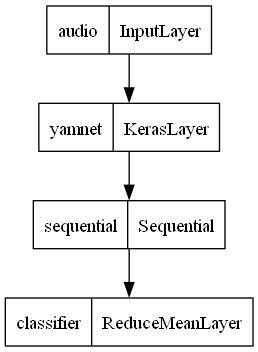

In [29]:
tf.keras.utils.plot_model(serving_model)


Load your saved model to verify that it works as expected

Stand-alone Testing

In [5]:
saved_model_path = 'custom_classes_yamnet'

In [6]:
reloaded_model = tf.saved_model.load(saved_model_path)

And for the final test: given some sound data directly

In [9]:
testing_wav_file_name = r'AudioSet\new_created\Clicking\mouse_click_26_aug_comb_PitchShift_TimeStretch_AddGaussianNoise_aug.wav'

testing_wav_data = load_wav_16k_mono(testing_wav_file_name)

In [11]:
# Your specified classes
my_classes = ['Silence', 'Male speech, man speaking', 'Female speech, woman speaking', 
              'Vacuum cleaner', 'Computer keyboard', 'Clicking', 'Sneeze', 
              'Cough', 'Laughter', 'Hair dryer', 'book_page_flip']

In [14]:
reloaded_results = reloaded_model(testing_wav_data)
probabilities = tf.nn.softmax(reloaded_results).numpy()
predicted_class_index = tf.math.argmax(reloaded_results).numpy()
predicted_class = my_classes[predicted_class_index]

print("Probabilities:")
for i, prob in enumerate(probabilities):
    print(f"{my_classes[i]}: {prob:.4f}")

print(f'\nThe main sound is: {predicted_class} with probability {probabilities[predicted_class_index]:.4f}')


Probabilities:
Silence: 0.0000
Male speech, man speaking: 0.0000
Female speech, woman speaking: 0.0000
Vacuum cleaner: 0.0000
Computer keyboard: 0.0000
Clicking: 0.3376
Sneeze: 0.1743
Cough: 0.3251
Laughter: 0.0713
Hair dryer: 0.0000
book_page_flip: 0.0918

The main sound is: Clicking with probability 0.3376


If you want to try your new model on a serving setup, you can use the 'serving_default' signature.

In [13]:
serving_results = reloaded_model.signatures['serving_default'](testing_wav_data)
predicting_1 = my_classes[tf.math.argmax(serving_results['classifier'])]
print(f'The main sound is: {predicting_1}')

The main sound is: Clicking
